## Preprocessing

In [1]:
user = 'Zihan'
model_name = 'CNN'

In [2]:
import sys
import json

print ("Initializing global variables...", end=' ')
sys.stdout.flush()

# Filepaths
dict_path = './' + user + '/dictionaries/'
model_path = './' + user + '/models/'
hist_path = './' + user + '/histories/'
fig_path = './' + user + '/figs/'

# shared result file
output_file = './results.txt'

print ("Done")
print ("  Filepath set to " + user + "'s directory")

##################################################

print ("Importing modules...", end=' ')
import modules
print ("Done")

##################################################

print ("Reading data from disk...", end=' ')
sys.stdout.flush()

import numpy as np
import pandas as pd

df = pd.read_parquet('./Tian/Metal_all_20180116.snappy.parquet')

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)

del df,df_zn,df_zn_single

# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i]:
        rows_to_delete.append(i)        
        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
print ("Done")

##################################################

print ("Loading dictionaries...", end=' ')
sys.stdout.flush()

# FOFE
vocab_dic_fofe = {}
with open(dict_path + "vocab_dict_fofe", 'r') as fp:
        vocab_dic_fofe = json.load(fp)

# # ProtVec
# seqs_dict_w2v = {}
# with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
#         seqs_dict_w2v = json.load(fp)

# # One-hot
# seqs_dict_onehot = {}
# with open(dict_path + "seqs_dict_onehot", 'r') as fp:
#         seqs_dict_onehot = json.load(fp)

# # property
# # blosum62
# from proteinSequenceEncoder import property_encoder, blosum62_encoder 
# AMINO_ACIDS21 = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', \
#                  'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
# seqs_property = {}
# seqs_blosum62 = {}
# seqs_onehot_blosum = {}

# for aa in AMINO_ACIDS21:
#     seqs_property[aa] = property_encoder(aa)
#     seqs_blosum62[aa] = blosum62_encoder(aa)
#     if aa != 'X' and aa !='U':
#         seqs_onehot_blosum[aa] = seqs_dict_onehot[aa] + blosum62_encoder(aa)[0]


print ("Done")

##################################################

print ("Performing cross validation split...", end=' ')
ratio = 0.9
split = int(ratio*len(seqs))
train_seqs, val_seqs = seqs[:split], seqs[split:]
train_label, val_label = target[:split], target[split:]
print ("Done")
print ("  Ratio :", ratio)
print ("  Train_range :", 0, "-", split-1)
print ("  Val_range :", split, "-", len(seqs)-1)

Initializing global variables... Done
  Filepath set to Zihan's directory
Importing modules... 

Using TensorFlow backend.


Done
Reading data from disk... Done
Loading dictionaries... Done
Performing cross validation split... Done
  Ratio : 0.9
  Train_range : 0 - 20504
  Val_range : 20505 - 22783


## Data Generator

- <font color=blue>FOFE Encoding</font>

In [3]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': vocab_dic_fofe}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': vocab_dic_fofe}
common_args = {'batch_size': 100,
               'input_shape': (800,),
               'label_shape': (706, ),
               'shuffle': True}

train_gen = modules.FOFEGenerator(**train_args, **common_args)
val_gen = modules.FOFEGenerator(**val_args, **common_args)

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_onehot}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_onehot}
common_args = {'batch_size': 100,
               'input_shape': (706, 20),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_w2v}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_w2v}
common_args = {'batch_size': 100,
               'input_shape': (706, 100),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.ProtVecGenerator(**train_args, **common_args)
val_gen = modules.ProtVecGenerator(**val_args, **common_args)

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_property}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_property}
common_args = {'batch_size': 100,
               'input_shape': (706, 7),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_blosum62}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_blosum62}
common_args = {'batch_size': 100,
               'input_shape': (706, 20),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

- <font color=blue>One-hot + Blosum62 Encodings</font>

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_onehot_blosum}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_onehot_blosum}
common_args = {'batch_size': 100,
               'input_shape': (706, 40),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

## Model
- <font color=blue>CNN</font>

In [4]:
# ProtVec:100, One-hot:20, blosum62:20, property:7
dimension = 800
cutoff = 706

import tensorflow as tf
import time
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Reshape, Embedding, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD
import numpy as np
import keras
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
# Visualization
from keras.utils import plot_model

input_shape = (dimension,)
lstm_size = 64

input_0 = Input(shape=input_shape, dtype='float32')
input_0_reshape = Reshape((1,dimension,1), input_shape=(dimension,))(input_0)
conv2d_3 = Convolution2D(2, 1, 3, border_mode='same')(input_0_reshape)
conv2d_5 = Convolution2D(2, 1, 5, border_mode='same')(input_0_reshape)
conv2d_7 = Convolution2D(2, 1, 7, border_mode='same')(input_0_reshape)

x = keras.layers.concatenate([conv2d_3,conv2d_5,conv2d_7])
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(cutoff, activation='relu')(x)
output_0 = Dense(cutoff, activation='softmax')(x)
#output_0_reshape = Reshape((cutoff,1), input_shape=(cutoff,))(output_0)

#model = Model(inputs=input_0, outputs=output_0_reshape)
model = Model(inputs=input_0, outputs=output_0)                              
# end of the MODEL

sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 800)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 800, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 800, 2)    8           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 800, 2)    12          reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_3 (

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 3), padding="same")`
D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 5), padding="same")`
D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 7), padding="same")`


- <font color=blue>Threshold: mean+2.33*std</font>

In [5]:
def threshold_func(y_in):
    factor = 2.33
    y_out = np.zeros_like(y_in)
    for i in range(y_in.shape[0]):
        th= np.mean(y_in[i]) + factor * np.std(y_in[i])
        y_out[i] = (y_in[i] > th)
    return y_out

- <font color=blue>Metric: F1 score</font>

In [6]:
cb = modules.F1_history(threshold_func)

model_args = {'model': model, 
              'generators': [train_gen, val_gen], 
              'callbacks': [cb], 
              'post_train_args': {'user': user, 
                                  'model': model_name, 
                                  'result': output_file, 
                                  'fig_path': fig_path}}

trainer = modules.Trainer(**model_args)

Epoch 1/10
205/205 [==============================] - 78s 379ms/step - loss: 9.5525 - acc: 0.1888 - val_loss: 9.5891 - val_acc: 0.1914
Epoch 2/10
205/205 [==============================] - 75s 367ms/step - loss: 8.6382 - acc: 0.2062 - val_loss: 9.1109 - val_acc: 0.2132
Epoch 3/10
205/205 [==============================] - 74s 362ms/step - loss: 8.1176 - acc: 0.2160 - val_loss: 8.6468 - val_acc: 0.2009
Epoch 4/10
205/205 [==============================] - 74s 360ms/step - loss: 7.7973 - acc: 0.2141 - val_loss: 8.4672 - val_acc: 0.1764
Epoch 5/10
205/205 [==============================] - 74s 363ms/step - loss: 7.5751 - acc: 0.2184 - val_loss: 8.3771 - val_acc: 0.1927
Epoch 6/10
205/205 [==============================] - 73s 357ms/step - loss: 7.4031 - acc: 0.2230 - val_loss: 8.0882 - val_acc: 0.2441
Epoch 7/10
205/205 [==============================] - 74s 359ms/step - loss: 7.2769 - acc: 0.2238 - val_loss: 8.0395 - val_acc: 0.2059
Epoch 8/10
205/205 [==============================] - 7

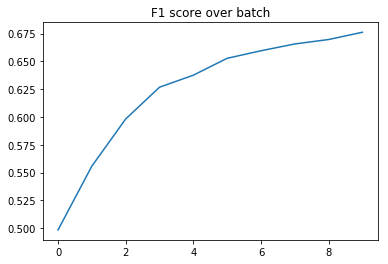

In [8]:
import warnings; 
warnings.simplefilter('ignore')
trainer.start(epoch=10)